# 🌍 HELP International: Clustering Countries for Targeted Aid

Analyzing socio-economic indicators to guide resource allocation and identify vulnerable regions.

## 1. 📘 Project Intro & Problem Framing

---

### 🕊️ HELP International's Mission
HELP International is a humanitarian NGO committed to reducing global poverty and strengthening community resilience through targeted aid. With a focus on regions suffering from natural disasters, economic instability, and systemic underdevelopment, HELP channels funds toward initiatives that improve health, infrastructure, and socio-economic outcomes in underserved nations.

---

### The Real-World Challenge
Despite raising $10 million in aid funding, HELP International faces a common global dilemma: **limited resources, unlimited need.** Dozens of countries present compelling cases for support, but the organization must make **data-backed, ethical, and efficient decisions** about where to deploy funds for maximum impact.

---

### Introducing Vulnerability Modeling
This project introduces a **vulnerability modeling framework** to aid in that decision-making process -- using **unsupervised machine learning** to group countries based on **health, economic, and demographic indicators**. By clustering nations according to shared structural challenges (rather than surface-level assumptions), we can **strategically identify the most vulnerable groups**, ensuring that aid allocation aligns with both **urgency and long-term development goals**.

---

## 2. 📂 Data Import & Overview

---

In [58]:
%pip install "kaleido==0.2.1"

  Using cached kaleido-0.2.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (15 kB)
Using cached kaleido-0.2.1-py2.py3-none-macosx_11_0_arm64.whl (85.8 MB)
  Attempting uninstall: kaleido
    Found existing installation: kaleido 1.0.0
    Uninstalling kaleido-1.0.0:
      Successfully uninstalled kaleido-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
# 📦 Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import kaleido
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Optional: Configure display settings for cleaner output
pd.set_option('display.max_columns', None)

In [3]:
# 📂 Load the dataset
df = pd.read_csv('../data/Country-data.csv')

# 🔍 Preview the data
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
# Shape of dataset
df.shape

(167, 10)

In [7]:
# Data types and non-null counts
df.info()

# Summary Statistics
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [9]:
# Total missing values per column
df.isnull().sum()

# Percentage of missing values
df.isnull().mean().round(4) * 100

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

In [11]:
# Make all column names lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Drop duplicates (precautionary)
df = df.drop_duplicates()

# Check for any negative values in numeric columns (just in case)
neg_check = (df.select_dtypes(include=['float64', 'int64']) < 0).sum()
print("\n⚠️ Negative Values Check:\n", neg_check[neg_check > 0])


⚠️ Negative Values Check:
 inflation    8
dtype: int64


In [13]:
# View rows with negative inflation values
df[df['inflation'] < 0]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
10,Bahamas,13.8,35.0,7.89,43.7,22900,-0.393,73.8,1.86,28000
43,Czech Republic,3.4,66.0,7.88,62.9,28300,-1.430,77.5,1.51,19800
73,Ireland,4.2,103.0,9.19,86.5,45700,-3.220,80.4,2.05,48700
77,Japan,3.2,15.0,9.49,13.6,35800,-1.900,82.8,1.39,44500
85,Latvia,7.8,53.7,6.68,55.1,18300,-0.812,73.1,1.36,11300
131,Seychelles,14.4,93.8,3.40,108.0,20400,-4.210,73.4,2.17,10800
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600
135,Slovenia,3.2,64.3,9.41,62.9,28700,-0.987,79.5,1.57,23400


### ⚠️ Countries with Negative Inflation
The following countries reported deflation (negative inflation values) in the dataset, which may indicate economic contraction or price declines during the period measured.

---

## 📖 Reference: Data Dictionary

> This table defines each dataset column, ensuring clarity and consistency in interpreting results.  
> *(Click to expand)*

---

<details>
<summary> View Data Dictionary</summary>

| Column Name  | Description |
|--------------|-------------|
| **country** | Name of the country |
| **child_mort** | Death of children under 5 years of age per 1,000 live births |
| **exports** | Exports of goods and services per capita, as a % of GDP per capita |
| **health** | Total health spending per capita, as a % of GDP per capita |
| **imports** | Imports of goods and services per capita, as a % of GDP per capita |
| **income** | Net income per person |
| **inflation** | Annual growth rate of the total GDP |
| **life_expec** | Average number of years a newborn would live given current mortality patterns |
| **total_fer** | Average number of children born per woman, assuming current age-specific fertility rates |
| **gdpp** | GDP per capita (Total GDP divided by total population) |

</details>

## 3. 📊 Exploratory Data Analysis (EDA)
To build an ethical and effective **vulnerability model**, it’s critical to understand the socio-economic dynamics at play. This section explores how development indicators relate to one another — surfacing structural patterns that justify deeper clustering.

---

**📊 Primary Goals**
- Understand **distributional imbalances** between countries
- Reveal **economic disparities and health gaps**
- Detect **non-obvious correlations** that signal underlying vulnerabilities.

**Inflation Distribution**

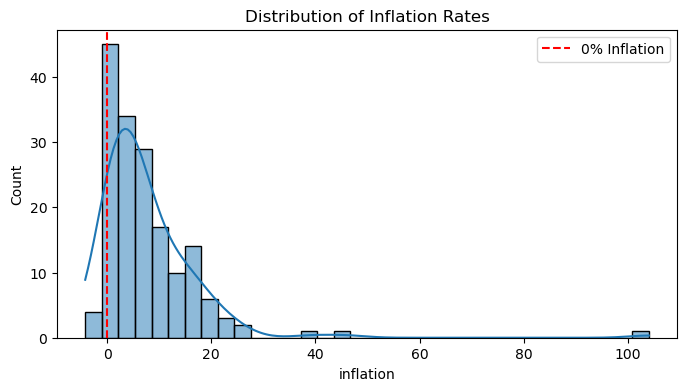

In [21]:
# Inflation distribution plot
plt.figure(figsize=(8, 4))
sns.histplot(df['inflation'], kde=True)
plt.axvline(0, color='red', linestyle='--', label='0% Inflation')
plt.title('Distribution of Inflation Rates')
plt.legend()
plt.show()

### 📉 Inflation Distribution Insights

The distribution of inflation rates among countries is **positively skewed**, with the majority of countries experiencing inflation rates between **0% and 15%**. A small number of countries fall into the **hyperinflation** range (40%+), creating a long right tail.

Interestingly, a few countries — including Japan, Ireland, and Singapore — show **negative inflation**, confirming the presence of **deflation** within the dataset. This is economically plausible and typically seen in highly developed economies during periods of stagnation or economic contraction.

This distribution supports keeping inflation as a modeling feature, as it introduces a distinct axis of **economic volatility** that isn't strongly correlated with development metrics like GDP or life expectancy.

---

**Correlation Heatmap**

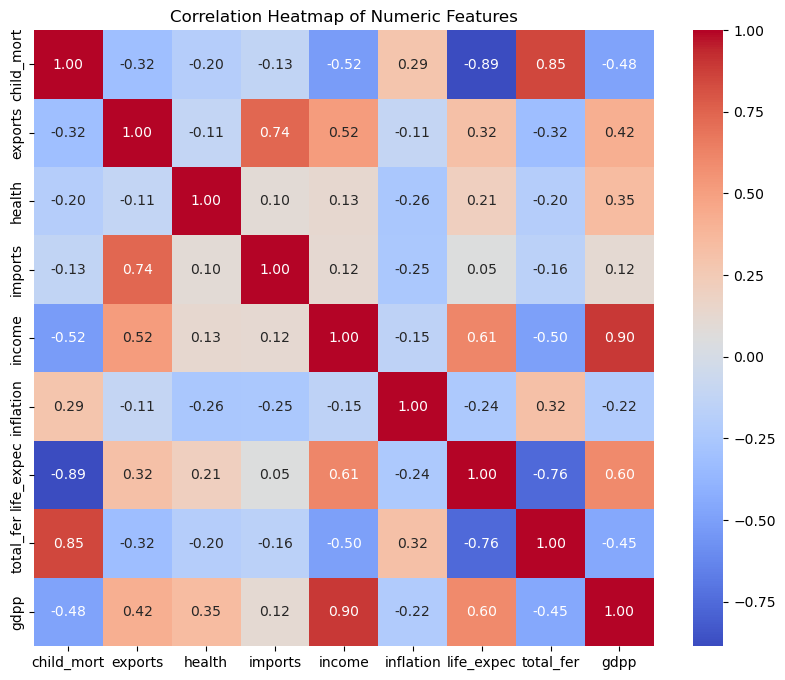

In [25]:
# Correlation heatmap with numeric columns only
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### 🔍 Correlation Insights

The correlation heatmap reveals several strong relationships between health, economic, and demographic indicators:

- **Child mortality** is strongly **negatively correlated** with life expectancy (-0.89) and **positively correlated** with total fertility (0.85), indicating that high fertility and poor health outcomes tend to co-occur in vulnerable countries.
- **GDP per capita** is highly correlated with both income (0.90) and life expectancy (0.60), suggesting strong overlap among economic development indicators.
- **Inflation** shows weak correlations across most variables, indicating that it may represent a separate axis of economic instability worth modeling independently.

These relationships will help inform feature selection for later modeling steps and may also suggest natural groupings for countries based on development profiles.

---

**Boxplots**

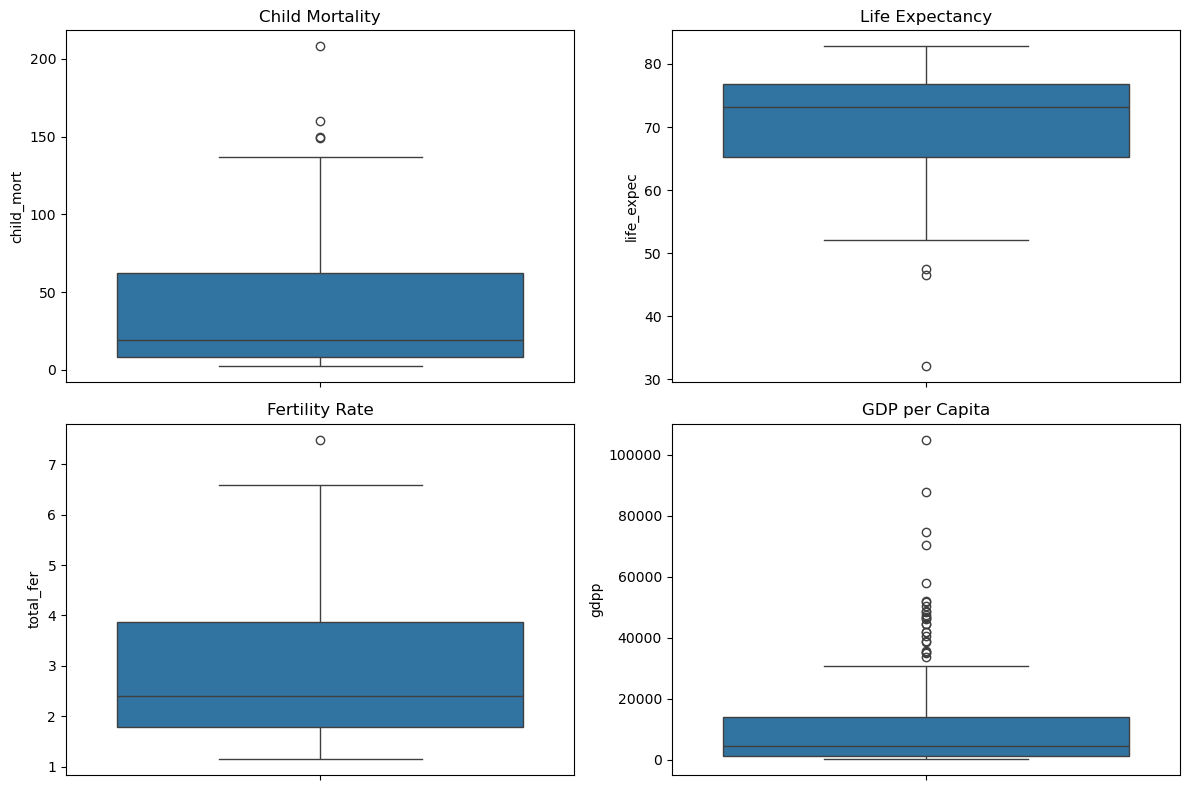

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.boxplot(data=df, y='child_mort', ax=axes[0, 0]).set_title('Child Mortality')
sns.boxplot(data=df, y='life_expec', ax=axes[0, 1]).set_title('Life Expectancy')
sns.boxplot(data=df, y='total_fer', ax=axes[1, 0]).set_title('Fertility Rate')
sns.boxplot(data=df, y='gdpp', ax=axes[1, 1]).set_title('GDP per Capita')
plt.tight_layout()

### 📦 Boxplot Insights: Development Indicators

The boxplots reveal critical disparities in global development:

- **Child Mortality** shows a wide distribution with several extreme outliers, indicating deeply unequal access to pediatric and maternal care.
- **Life Expectancy** is mostly concentrated between 65–80 years, but countries below this range likely face ongoing humanitarian or infrastructure crises.
- **Fertility Rate** displays a small number of high outliers (above 6 children per woman), typically correlated with poor health infrastructure and low female education levels.
- **GDP per Capita** is heavily right-skewed, with a majority of countries earning under $10,000 per person and a few high-income nations pulling the average upward.

These trends support the need for normalization prior to clustering and highlight the socioeconomic divide this model aims to address.

---

**Pairplot of KDIs**

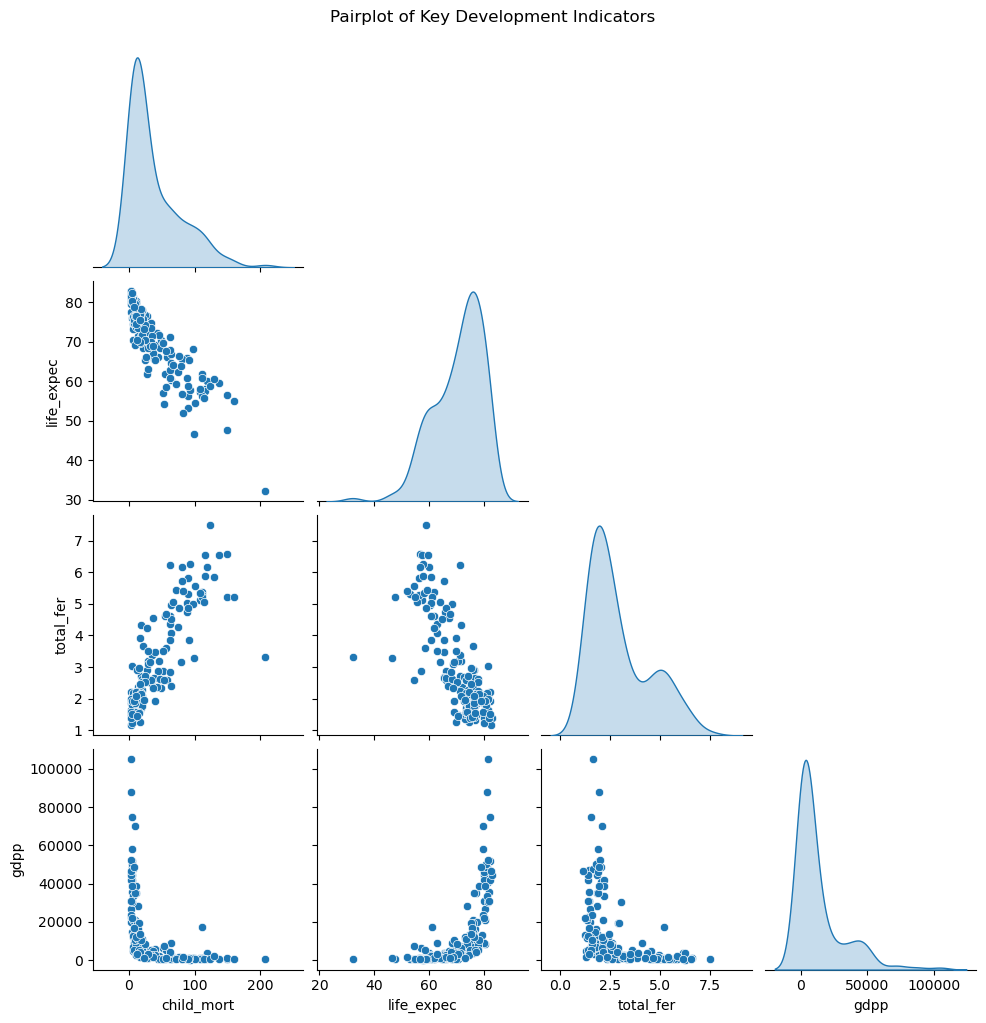

In [33]:
# Focus on your strongest development indicators
pairplot_features = ['child_mort', 'life_expec', 'total_fer', 'gdpp']

# Create pairplot
sns.pairplot(df[pairplot_features], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Key Development Indicators', y=1.02)
plt.show()

### 🔗 Pairplot Insights

This pairplot highlights key relationships among core development indicators:

- **Child Mortality** has a strong inverse relationship with both **GDP per capita** and **life expectancy**, and a positive relationship with **fertility rate** — reinforcing its role as a proxy for national vulnerability.
- **Fertility Rate** shows non-linear trends but aligns closely with both child mortality and life expectancy, further connecting health outcomes to demographic patterns.
- **GDP per capita** is positively associated with life expectancy and negatively associated with child mortality and fertility, but its right-skewed distribution suggests wide economic disparity.

These visuals support the need for **scaling** and potentially **dimensionality reduction (PCA)** before clustering, while confirming the potential for natural groupings based on shared socio-economic and health characteristics.

---

**Histogram Analysis: Final EDA Observations**

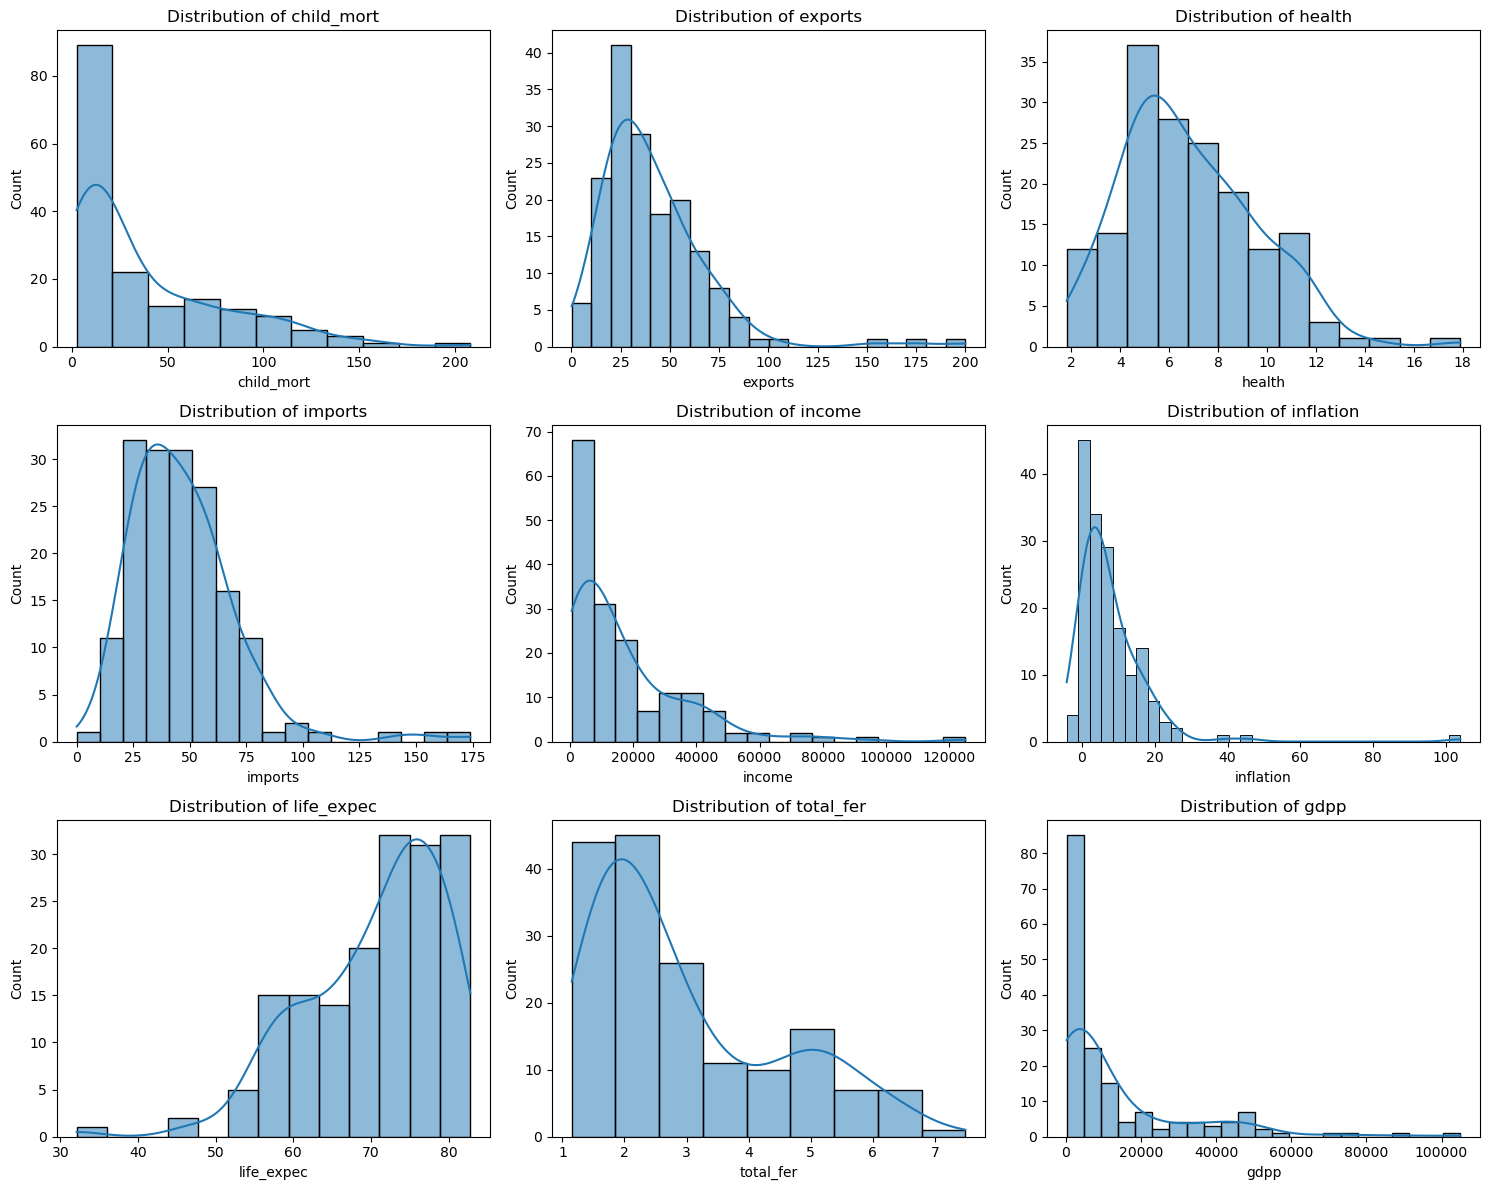

In [36]:
# Select numeric columns only
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Create subplots: adjust layout based on number of features
n = len(numeric_cols)
rows = (n // 3) + (n % 3 > 0)
fig, axes = plt.subplots(rows, 3, figsize=(15, 4 * rows))
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 📊 Final Histogram Insights

The histogram grid reveals important distribution patterns across all numerical features:

- **Child Mortality**, **GDP per capita**, and **Income** are heavily right-skewed, with a small number of countries experiencing extreme poverty, low development, or high inequality.
- **Inflation**, **Exports**, and **Imports** show similar skewed distributions, reflecting the rarity of extreme economic conditions or trade imbalances.
- **Life Expectancy** is more normally distributed, with clear separations between lower- and higher-developed nations.
- **Fertility Rate** displays a wide spread, with high values typically associated with more vulnerable populations.

These patterns validate the need for **feature scaling** before modeling and confirm the presence of **natural variance** in the data — a strong foundation for applying unsupervised learning techniques like PCA and clustering.

---

## 4. ⚖️ PCA: Variance Reduction

Before we can cluster countries based on their structural vulnerability, we must prepare the dataset to ensure that all features are on a comparable scale and free of redundancy.

---

### Why Scaling is Necessary

The exploratory analysis revealed that several features — such as **GDP per capita**, **child mortality**, and **income** — are heavily skewed with vastly different ranges. For example, GDP values span from a few hundred to over $100,000, while fertility rates typically range from 1 to 7. These scale imbalances can distort distance-based models like **K-Means** or **Hierarchical Clustering**, where large-scale variables disproportionately influence the results.

To address this, we will use **RobustScaler**, a normalization technique less sensitive to extreme outliers, to center and scale all numeric features.

---

### Why PCA is Used

Our correlation heatmap and pairplots revealed strong multicollinearity among some features — notably between **GDP per capita** and **income**, and between **child mortality** and **fertility rate**.

To reduce dimensionality, remove redundancy, and simplify our modeling space without losing variance, we will apply **Principal Component Analysis (PCA)**. PCA will create uncorrelated linear combinations of our original variables (called components), preserving most of the information while making the data easier to cluster.

---

Together, **scaling and PCA** will transform our dataset into a clean, efficient space where we can meaningfully identify groups of countries based on shared structural challenges.

In [43]:
# Define the features to use for modeling
features = [
    'child_mort',
    'exports',
    'health',
    'imports',
    'inflation',
    'life_expec',
    'total_fer',
    'gdpp'  
]

# Store the data to be scaled
X = df[features]

# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

**PCA Implementation**

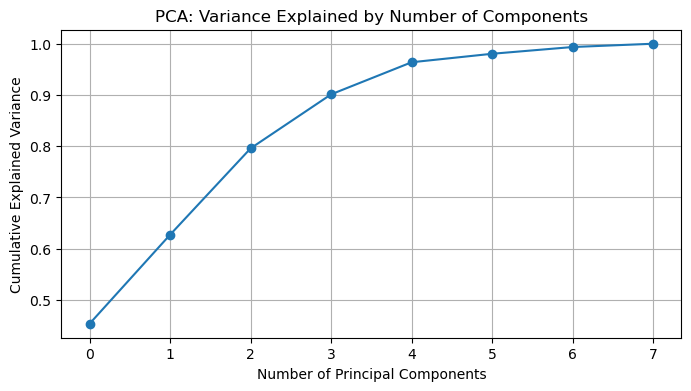

In [46]:
# Initialize and fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Variance Explained by Number of Components')
plt.grid(True)
plt.show()

### ✅ PCA Interpretation: Dimensionality Reduction

The PCA scree plot shows that the first **four principal components** capture approximately **96%** of the total variance in the dataset. This means we can reduce our feature space from 8 variables to just 4 principal components without sacrificing meaningful information.

By transforming our data into this reduced-dimensional space, we:
- Eliminate redundancy from multicollinearity
- Preserve major patterns of variation across countries
- Simplify the dataset for effective and interpretable clustering

We will now proceed to model countries using these 4 components as the foundation for unsupervised grouping.

In [49]:
# Reduce to 4 components based on explained variance
pca_final = PCA(n_components=4)
X_reduced = pca_final.fit_transform(X_scaled)

# Optional: create DataFrame for clarity
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(4)])

In [51]:
# Evaluate K from 2 to 10
wcss = []
sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    
    wcss.append(kmeans.inertia_)  # Within-cluster sum of squares
    sil_scores.append(silhouette_score(X_reduced, kmeans.labels_))  # Silhouette

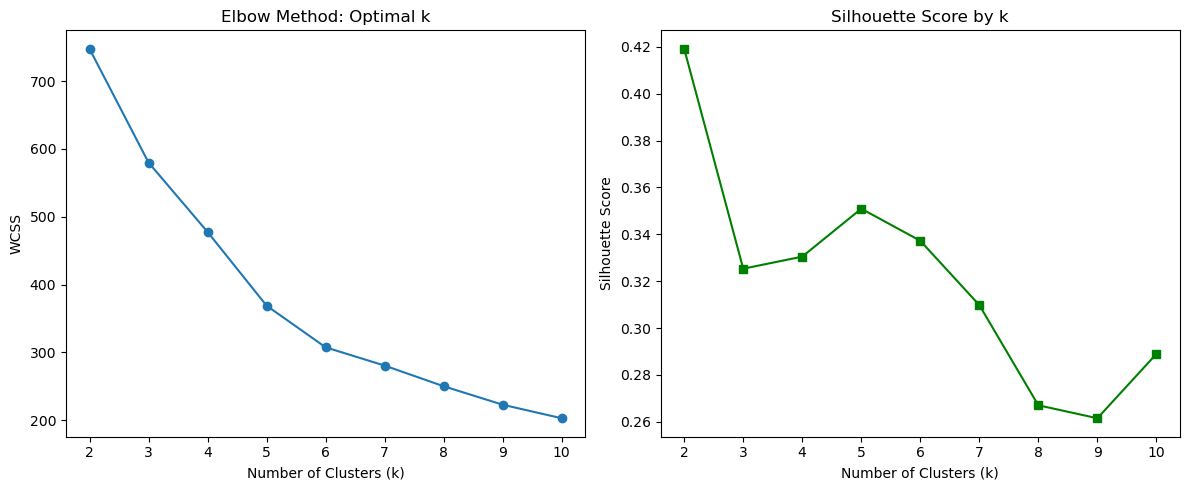

In [53]:
# Elbow plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')

# Silhouette plot
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), sil_scores, marker='s', color='green')
plt.title('Silhouette Score by k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

#### 🔎 Cluster Validation Insights

The Elbow Method suggests that the ideal number of clusters lies around **k = 4**, where the within-cluster variance begins to level off. Meanwhile, the Silhouette Score remains relatively high (≈ 0.33–0.35) for `k = 4–5`, indicating a good balance between internal cohesion and separation.

While `k = 2` offers the highest silhouette score, it likely oversimplifies the dataset. Therefore, we select **`k = 4`** to ensure more nuanced and actionable insights across country development profiles.

This sets the stage for our final clustering step.

## 	5. 🎯 Clustering: KMeans + Validation

---

In [57]:
# Initialize KMeans with the selected number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_reduced)

# Store cluster labels
df['cluster'] = kmeans.labels_
X_reduced_df['cluster'] = kmeans.labels_

The dataset has been segmented into four clusters using the KMeans algorithm (with PCA-reduced features).  
Cluster labels are now stored in both the original DataFrame (`df`) and the PCA-reduced DataFrame (`X_reduced_df`) for further analysis and visualization.

---

## 6. 📈 Visualization: PCA Projection of Clusters

---

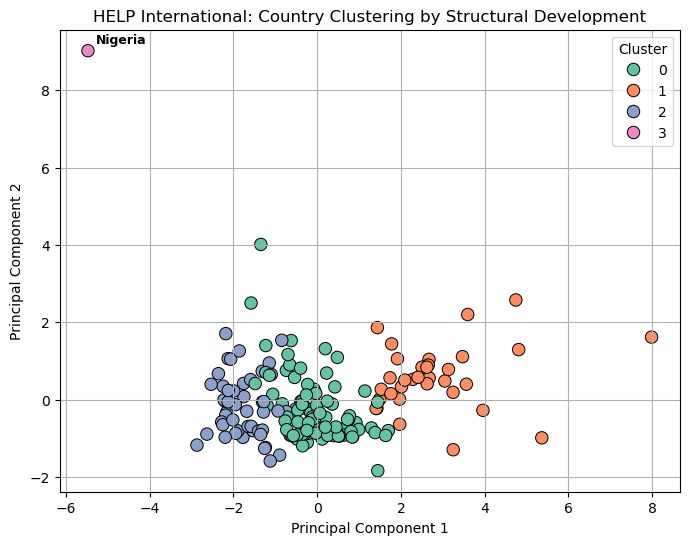

In [62]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_reduced_df['PC1'], 
    y=X_reduced_df['PC2'], 
    hue=X_reduced_df['cluster'], 
    palette='Set2', 
    s=80, edgecolor='black'
)

# Highlight outlier(s)
outlier_df = df[df['cluster'] == 3]
for i in outlier_df.index:
    plt.text(
        X_reduced_df.loc[i, 'PC1'] + 0.2, 
        X_reduced_df.loc[i, 'PC2'] + 0.2, 
        df.loc[i, 'country'], 
        fontsize=9, 
        weight='bold', 
        color='black'
    )

plt.title('HELP International: Country Clustering by Structural Development')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

- **PC1** primarily reflects economic strength (e.g., GDP per capita, income)
- **PC2** captures health/demographic characteristics (e.g., life expectancy, fertility rate)

---

## 7. 🗺 Geographic Distribution of Clusters

While the PCA scatter plot shows the separation of clusters in reduced feature space, a choropleth map places these groups back into a real-world geographic context. This visualization helps connect structural vulnerability to specific regions, making the findings more tangible for policy and aid allocation discussions.

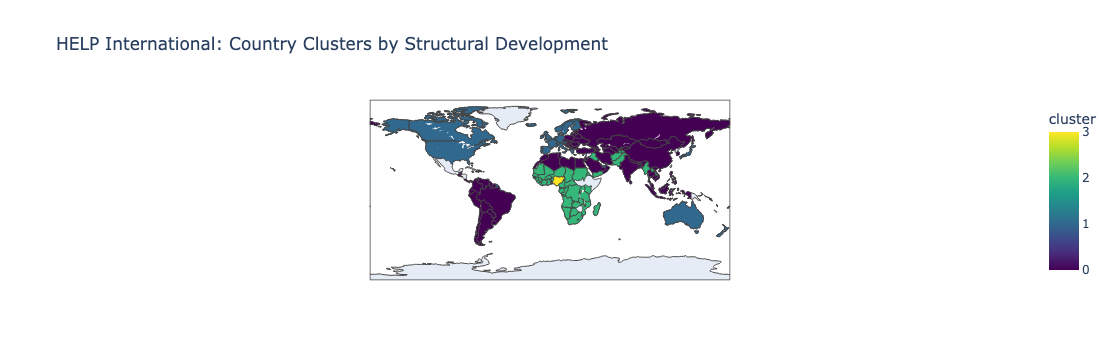

In [69]:
# Create choropleth map for clusters
fig = px.choropleth(
    df,
    locations='country',              # Column with country names
    locationmode='country names',     # Let Plotly know these are names, not codes
    color='cluster',                  # Cluster assignments
    title='HELP International: Country Clusters by Structural Development',
    color_continuous_scale='Viridis'  # Choose any color scale you like
)

fig.show()

# --- EXPORTS ---

# 1) static PNG for GitHub README (requires kaleido)
fig.write_image("../images/cluster_map.png", scale=2)  # scale=2 for sharper image

# 2) interactive HTML you can link from README
fig.write_html("../images/cluster_map.html", include_plotlyjs="cdn")

## 8. 📊 Cluster Profiles: Structural Summary

To interpret each cluster meaningfully and tie it back to HELP International’s mission, we compute the average values of key development indicators for each group.

This summary highlights structural strengths and vulnerabilities — allowing us to understand **what defines each group** beyond visual separation.

---

In [72]:
# Define modeling features for summary stats
features = [
    'child_mort', 'exports', 'health', 'imports',
    'inflation', 'life_expec', 'total_fer', 'gdpp'
]

# Calculate mean of each feature per cluster
cluster_summary = df.groupby('cluster')[features].mean().round(2)

# Optional: Add count of countries per cluster
cluster_summary['# of Countries'] = df['cluster'].value_counts().sort_index()

print("📊 Cluster Summary by Structural Grouping")
display(cluster_summary)

📊 Cluster Summary by Structural Grouping


,child_mort,exports,health,imports,inflation,life_expec,total_fer,gdpp,# of Countries
cluster,,,,,,,,,
0,20.40,42.26,6.28,48.51,7.40,73.12,2.26,6992.19,85
1,5.17,57.22,8.98,50.29,2.61,80.28,1.78,44806.06,33
2,90.75,28.33,6.32,42.30,10.01,59.54,4.91,1869.75,48
3,130.00,25.30,5.07,17.40,104.00,60.50,5.84,2330.00,1


---

## 	9. 🧭 Final Aid Strategy Recommendation

Each cluster represents a distinct structural profile of countries:

- **Cluster 2**: Extremely high child mortality, low GDP per capita, and short life expectancy — indicating **severe vulnerability** and urgent need for aid.
- **Cluster 0**: Moderate child mortality and GDP per capita — potential for **targeted growth interventions** to improve health and economic outcomes.
- **Cluster 1**: Low child mortality, high GDP per capita, and strong health metrics — these countries are **structurally stable** and may not require aid funding.
- **Cluster 3**: An **outlier** with extremely high inflation and child mortality but a small representation — requires **special handling** outside standard aid allocation.

This profile view turns abstract clusters into **actionable insights** for HELP International’s $10M aid allocation strategy.

---

## 	10.	📘 Conclusion & Next Steps

This project successfully developed a data-driven framework for clustering countries based on structural vulnerability, enabling HELP International to make more informed, ethical, and targeted aid allocation decisions.

---

### ✅ Key Outcomes:
- Used unsupervised learning (PCA + K-Means) to identify **4 distinct clusters** of countries based on economic, health, and demographic indicators.
- Highlighted **Cluster 2** as the most structurally vulnerable group in need of urgent intervention.
- Provided a transparent and scalable foundation for **resource allocation, partner engagement, and global development strategy**.

### 🚧 Limitations:
- This model does not account for real-time factors like ongoing conflict, climate crises, or refugee displacement.
- It assumes equal importance across selected indicators — future versions could apply **weighted vulnerability scores** or include **humanitarian crisis data**.

### ⏭️ Next Steps:
- **Map clusters to actual funding allocation scenarios** (e.g., $ allocation per country).
- Integrate this model with **geopolitical risk layers**, conflict indexes, or climate impact data.
- Present findings to stakeholders with visual dashboards (e.g., Tableau, Power BI, or interactive map).

This framework serves as a living decision tool that can evolve as new data becomes available — and as HELP International's mission continues to grow.